# WE10-RNN
# Bapuji Satyala 
# U61600601

## Predicting 10th day Closing Stock  price of the Meta Platforms

Our Objective is to predict the 10th day closing stock price of the Meta platforms, This data has been fetched from yahoo Finance there by using the techniques RNN, LTSM, Gru, and Conv1D.The data ghas been fetched from May 18th 2012 till April 18th 2024 and predicting the next day stock price where there are 2987 observations which means there are 2987 stock data as we are predicting the closing price this s a regression problem.

## Importing the required libraries that we will be using in this note book.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
np.random.seed(1)
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D
tf.random.set_seed(1)
import time
from tensorflow.keras.callbacks import EarlyStopping

epoch_num = 100 # this needs to be set much higher if we are to get a good model -- but, higher number of epochs takes more training time

###  Step 1: Reading the data and data  Preprocessing 

Here we are reading the data into a dataframe from a csv file which contains the stock prices data of the meta platforms

In [2]:
df = pd.read_csv('META.csv',  parse_dates=True)


Now we are looking at the top 5 observations of the dataframe which contain the stock price data

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.189480,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,33.993931,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,30.967144,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,31.966084,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,32.994991,50237200


Lets look at the columns of the dataframe 

In [4]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

Lets replace the spaces in the column names with underscore

In [5]:
df.columns = df.columns.str.replace(' ', '_')

Here we are converting the column name to uppercase

In [6]:
df.columns = df.columns.str.upper()

As we require only the closing price of the stock we will be dropping the columns that are not required for the prediction

In [7]:
df = df.drop(['HIGH', 'LOW', 'ADJ_CLOSE', 'VOLUME','DATE','OPEN'], axis=1)

Lets look at the shape of the data frame after dropping the columns.

In [8]:
df.shape

(2987, 1)

Lets look if there are null values present in the closing price column.

In [9]:
df['CLOSE'].isna().sum()

0

#### Plotting the Closing price of Meta

Lets look at the trend of the closing price of the Meta platform stock where we can see that there is gradual increase over the days between 0 to 1500 and there are sudden drops and  increases.

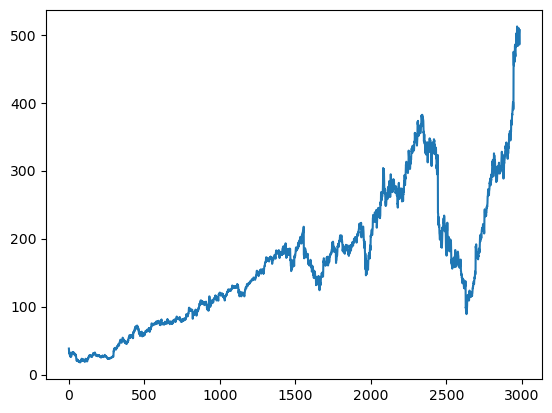

In [10]:
plt.plot(df['CLOSE'])
plt.show()

here we are storing the number of observations into a variable 

In [11]:
row_count = df.shape[0] # store the number of obersvations 
row_count

2987

As we are trying to predict the 10th day closing price by using the 9 days hence we are taking the sequence length as 10

In [12]:
sequence_length = 10

Here we are converting the dataframe into a numphy array

In [13]:
close = df.to_numpy() # to make things easier, we create a numpy array from our dataframe of temperatures
close.shape

(2987, 1)

Here we are dividing the total number of rows  by the specified sequence length this will give us better picture of how many data points need to be removed from the beginning of the data just to make the data points divisible by the sequence length such that slicing will be done.

In [14]:
close = close[row_count % sequence_length: ] # Since our data may not be a multiple of sequence_length, we will ignore 
# the first number of days in order to make the total a number divisible by sequence length
close.shape


(2980, 1)

Here we are creating the two dimensional array so that we are slicing the data points into crunches here wea re doing integer division and we are specifying the sequence length just to get the correct sequence of datapoints which we will use for training and testing the model.

In [15]:
close = close.reshape(row_count // sequence_length, sequence_length) # note that temps are a multiple of sequence length, we can split the data into rows of sequence length.
close

array([[ 28.190001,  29.6     ,  27.719999, ...,  27.1     ,  27.01    ,
         27.4     ],
       [ 27.27    ,  28.290001,  30.01    , ...,  33.049999,  32.060001,
         33.099998],
       [ 32.23    ,  31.360001,  31.1     , ...,  32.169998,  31.469999,
         30.969999],
       ...,
       [468.029999, 486.130005, 484.029999, ..., 502.299988, 498.190002,
        490.220001],
       [496.089996, 512.190002, 505.950012, ..., 484.100006, 496.980011,
        496.23999 ],
       [505.519989, 507.76001 , 509.579987, ..., 491.350006, 497.369995,
        506.73999 ]])

By using the index we are splitting the data into training and test sets while maintaining the order of the data. we are splitting the data into 80% as the train set and 20% as the test set

### Step2: Splitting the data into train and test sets using chronological splits. 

In [16]:
# if we needed to maintain the ordering of the data, we can use the following code to split the data
split_point = int(len(close)*0.8)
train, test = close[:split_point],close[split_point:]

We are considering the train inputs where we are considering all the rows and columns where we are not considering the last one as the target variable. 

In [17]:
train_inputs = train[:,:-1]

As we know that the recurring neural networks do require three dimensions hence we are introducing a new axis at the end of the array of dimension .

In [18]:
#Create an additional dimension for train

train_x = train_inputs[:,:,np.newaxis]

train_x.shape 

(238, 9, 1)

Here we can see that the shape of the array as three dimensional after adding one more dimention to the existing train data

Lets look at the contents as mentioned above it is of three dimensional array where there are 238 samples with 9 features and an additional feature.

In [19]:
train_x

array([[[ 28.190001],
        [ 29.6     ],
        [ 27.719999],
        ...,
        [ 26.309999],
        [ 27.1     ],
        [ 27.01    ]],

       [[ 27.27    ],
        [ 28.290001],
        [ 30.01    ],
        ...,
        [ 31.84    ],
        [ 33.049999],
        [ 32.060001]],

       [[ 32.23    ],
        [ 31.360001],
        [ 31.1     ],
        ...,
        [ 31.73    ],
        [ 32.169998],
        [ 31.469999]],

       ...,

       [[339.390015],
        [343.01001 ],
        [326.230011],
        ...,
        [330.049988],
        [325.450012],
        [323.769989]],

       [[328.529999],
        [324.76001 ],
        [335.339996],
        ...,
        [324.609985],
        [328.690002],
        [315.809998]],

       [[316.920013],
        [323.570007],
        [329.980011],
        ...,
        [341.130005],
        [338.619995],
        [335.369995]]])

Here we are slicing the last column and all the rows that are associated where we are slecting the last element of each sequence from the train data

In [20]:
train_target = train[:,-1]
train_target

array([ 27.4     ,  33.099998,  30.969999,  29.34    ,  20.719999,
        19.440001,  18.959999,  22.59    ,  21.950001,  18.98    ,
        21.25    ,  22.92    ,  27.459999,  27.709999,  27.77    ,
        30.139999,  29.73    ,  28.32    ,  27.719999,  26.49    ,
        25.42    ,  26.92    ,  27.77    ,  27.07    ,  23.32    ,
        23.77    ,  24.16    ,  25.809999,  34.360001,  38.540001,
        38.549999,  43.950001,  47.490002,  51.040001,  54.220001,
        49.75    ,  49.009998,  47.060001,  53.810001,  54.650002,
        57.599998,  61.080002,  67.330002,  68.459999,  67.720001,
        60.009998,  58.529999,  56.139999,  59.830002,  63.48    ,
        65.769997,  65.720001,  64.970001,  71.290001,  72.470001,
        74.809998,  75.949997,  77.      ,  77.080002,  72.629997,
        74.110001,  74.25    ,  77.699997,  77.830002,  80.019997,
        76.449997,  76.239998,  76.510002,  80.410004,  78.93    ,
        83.010002,  82.040001,  81.529999,  78.510002,  80.540

Lets looks at the dimensions of the test data where we can see there are 60 rows and 10 columns.

In [21]:
test.shape

(60, 10)

We are considering the test inputs where we are considering all the rows and columns where we are not considering the last one as the target variable. 

In [22]:
test_inputs = test[:,:-1]

As we know that the recurring neural networks do require three dimensions hence we are introducing a new axis at the end of the array of dimension .

In [23]:
test_x = test_inputs[:,:,np.newaxis]

test_x.shape 

(60, 9, 1)

Here we can see that the shape of the array as three dimensional after adding one more dimention to the existing train data

Here we are slicing the last column and all the rows that are associated where we are slecting the last element of each sequence from the test data

In [24]:
test_target = test[:,-1]

pd.DataFrame(test_target, columns=['10'])

,10
0,341.059998
1,329.820007
2,335.239990
3,331.790009
4,308.709991
5,224.910004
6,202.080002
7,190.289993
8,216.649994
9,231.839996


Here we are displaying the 10th column data which will be the last column data of all the rows.

### Step3: Defining and fitting the models.

### Recurrent Neural Network -  RNN

The Recurrent neural network works with the sequence data,the normal traditional neural networks they assume that the target and the features are indepdent of each other where the output of the recurrent neural networks depends on the prior elements within the sequence.The main difference from the traditional backpropogation is the recurrent neural networks leverage the backpropogationthrough time (BPPT) where the model will calculate and learns from the errors.The BPPT will add the errors at each step where the feedforward networks don't need to add. But with the process the RNN will run into problems of vanishing gradients. These recurrent neural network is a type of neural network where they use the output from the earlier step and feed it as input to the current one. While updating the weights of the  units these will be updated with smaller values when it is on the first place this problem is vanishing gradient problem. and the other problem is with the gradients may become very large during training.

In [25]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', input_shape=[9, 1]),
    keras.layers.Dense(1, activation=None)
])


C:\Users\bapuj\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


As this is regresor type problem as we are predicting the closing stock price we have considered the activation funcion as none in the output layer where as the input layer shape is 9 as the sequence is 9 as we are predicting the 10th day stock price and the activation function is relu, the relu will introduce the sparsity into the network by zeroing out the negative value. 

In [26]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

Here we are compiling the model by using the loss function as the Mean squared error where the nadam is used as the optimizer which is the combination nesterov acclerated gradiant with the adam optimization and the kearning rate is set to 0.001 which acts as hyperparameter that controls the step size of the gradient descent. we are considering the metric as the root mean squared error as this is a regression problem.Here we can see the total paramters that are trainable as 1121 

In [27]:
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=5, verbose=1, mode='auto')

history = model.fit(
    train_x, 
    train_target, 
    epochs=epoch_num,
    validation_data = (test_x,test_target), 
    callbacks=[early_stop]
)  

end_time = time.time()

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 23.7669 - root_mean_squared_error: 4.8558 - val_loss: 69.3626 - val_root_mean_squared_error: 8.4446
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.4162 - root_mean_squared_error: 4.1483 - val_loss: 66.9398 - val_root_mean_squared_error: 8.2899
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.4417 - root_mean_squared_error: 4.0222 - val_loss: 67.2763 - val_root_mean_squared_error: 8.3073
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15.6141 - root_mean_squared_error: 3.9137 - val_loss: 66.7781 - val_root_mean_squared_error: 8.2601
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15.1822 - root_mean_squared_error: 3.8559 - val_loss: 67.1861 - val_root_mean_squared_error: 8.2753
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.9501 - root_mean_squared_error: 3.8242 - val_loss: 67.7565 - val_root_mean_squared_error: 8.3035
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 

Here we are looking at the start and the end time for the traiing process and we are setting the early stopping which helps in stoopping the iterations ie the epochs to not perform training furtger if there is no change in the loss for certain number of epochs as the patience is set to 5 so if there is no change in the loss the training will stop  

Lets Plot the loss and the RMSE by varying the Epoch and as thre is no change for the loss as early stopping has been kept it has been stopped and we can see that early stopping has been done which will reduce the computational timne.

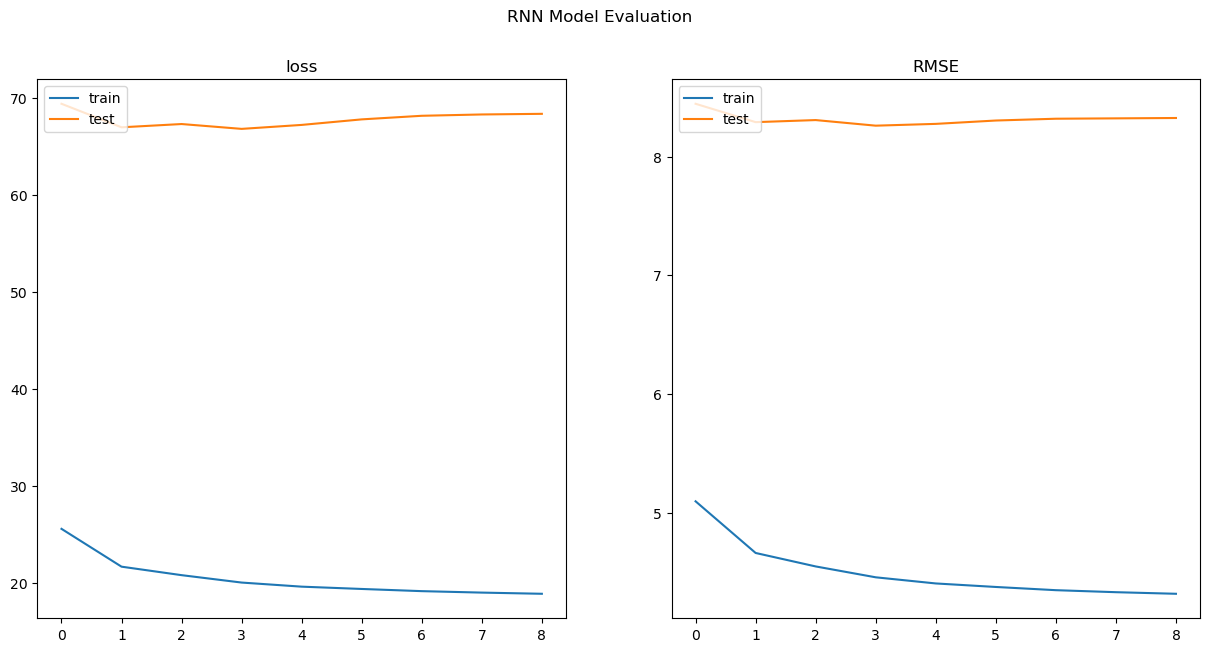

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

Lets Predict the model perfomance on the test data which we have considered as the 10th day  and we are calculating the Mean squared erorr between the actual and the predicted 

In [29]:
y_pred = model.predict(test_x)  

mean_squared_error(test_target, y_pred)**0.5

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


8.324803535724554

The Root Mean Squared error is 11.47

Lets Predict the 10th day closing price by using the model that has been trained on the train data

#### Predicting the 10th day closing price of Meta

I have considered the 9 day's data of the meta platforms stock price data from csv file and stored it into a data frame 

In [30]:
test = pd.read_csv('META_TEST.csv')
test

,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-04-05,516.859985,530.700012,514.409973,527.340027,527.340027,19242000
1,2024-04-08,529.280029,531.489990,518.890015,519.250000,519.250000,13260600
2,2024-04-09,522.229980,525.869995,506.739990,516.900024,516.900024,10881400
3,2024-04-10,509.290009,522.559998,505.799988,519.830017,519.830017,11418500
4,2024-04-11,521.109985,523.859985,517.289978,523.159973,523.159973,10369500
5,2024-04-12,517.750000,520.190002,509.329987,511.899994,511.899994,11944900
6,2024-04-15,516.719971,518.530029,497.279999,500.230011,500.230011,13512900
7,2024-04-16,498.109985,504.769989,497.109985,499.760010,499.760010,9847900
8,2024-04-17,503.100006,503.160004,487.140015,494.170013,494.170013,12193700


As we require only the closing price we are considering the Close data from the dataframe and converting it into a numphy array to feed it to the model.

In [31]:
prior_days = test['Close'].to_numpy()

Lets have a look at the data that is in array 

In [32]:
prior_days

array([527.340027, 519.25    , 516.900024, 519.830017, 523.159973,
       511.899994, 500.230011, 499.76001 , 494.170013])

As we know that the RNN require the data in three dimensional format we are reshaping the existing shape to three dimensional by adding new dimension 

In [33]:
prior_days = prior_days.reshape(1, 9, 1)

Lets use the 9 day data and predict the 10th day by using the RNN model that is trained.

In [34]:
model.predict(prior_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[497.7517]], dtype=float32)

We are slicing the predicted value from the numpy array where we can see it as 504.91

In [35]:
tomorrows_sp = model.predict(prior_days)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [36]:
print(f"Tomorrow's Stock price of Meta  is {tomorrows_sp:.2f} .")

Tomorrow's Stock price of Meta  is 497.75 .


### Long Short-Term Memory -  LSTM 

Long Short Term Memory  recurrent neural networks are the solutions to overcome the vanishing gradient where when the weights are updated via back propogation  they are updated in lower numbers, The hidden layer will remember some information about a sequence which is called as the memory state.There are three main components in the recurrent neural network that is the memory line, forget gate and the input and the output gate where the memory line will remember the sequence of the data.

In [37]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='relu', input_shape=[9, 1]),
    keras.layers.Dense(1, activation=None)
])

C:\Users\bapuj\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


As this is regresor type problem as we are predicting the closing stock price we have considered the activation funcion as none in the output layer where as the input layer shape is 9 as the sequence is 9 as we are predicting the 10th day stock price and the activation function is relu, the relu will introduce the sparsity into the network by zeroing out the negative values, and the input layer  has 32 neurons and the output layer have one neuron as this is a regressor probem. 

In [38]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Here we are compiling the model by using the loss function as the Mean squared error where the nadam is used as the optimizer which is the combination nesterov acclerated gradiant with the adam optimization and the kearning rate is set to 0.001 which acts as hyperparameter that controls the step size of the gradient descent. we are considering the metric as the root mean squared error as this is a regression problem.Here we can see the total paramters that are trainable as 4385

In [39]:
history = model.fit(train_x, train_target, epochs=epoch_num)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12923.1309 - root_mean_squared_error: 113.8908
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7311.7085 - root_mean_squared_error: 85.7757 
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1532.3413 - root_mean_squared_error: 38.9969 
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.0946 - root_mean_squared_error: 7.4779 
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86.0644 - root_mean_squared_error: 9.2458   
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51.1333 - root_mean_squared_error: 7.1469 
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.7186 - root_mean_squared_error: 5.8907 
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.1398 - root_mean_squared_error: 5.7542 
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.8306 - root_mean_squared_error: 5.9045 
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.8693 - root_mean_squared_er

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.5684 - root_mean_squared_error: 4.2838 
Epoch 62/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.5845 - root_mean_squared_error: 4.2875 
Epoch 63/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.8474 - root_mean_squared_error: 4.1973 
Epoch 64/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.2294 - root_mean_squared_error: 4.1193 
Epoch 65/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.9381 - root_mean_squared_error: 4.0848 
Epoch 66/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.6092 - root_mean_squared_error: 4.0436 
Epoch 67/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.3987 - root_mean_squared_error: 4.0159 
Epoch 68/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.1804 - root_mean_squared_error: 3.9887 
Epoch 69/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.0508 - root_mean_squared_error: 3.9734 
Epoch 70/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.8527 - root_mean_squared_error: 3.9479 
Epo

Here we are fitting the model after compiling, the train data has been fitted by the ephocs which are the iterations 

In [40]:
#Predict:
y_pred = model.predict(test_x)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Lets Predict the model perfomance on the test data which we have considered as the 10th day

Lets flatten the data as this is in three dimensional shape into one dimension to look at the plot of stock price that is actual and predicted 

In [41]:
comparison = pd.DataFrame()
comparison['actual'] = test_target.flatten()  
comparison['predicted'] = y_pred.flatten()

Calculating the mean squared error between the actual value and the predicted

In [42]:
mse = mean_squared_error(comparison['actual'], comparison['predicted'])**0.5
print(f" Root Mean Squared Error: {mse}")

 Root Mean Squared Error: 7.801983429550457


The Root Mean Squared error is 7.80

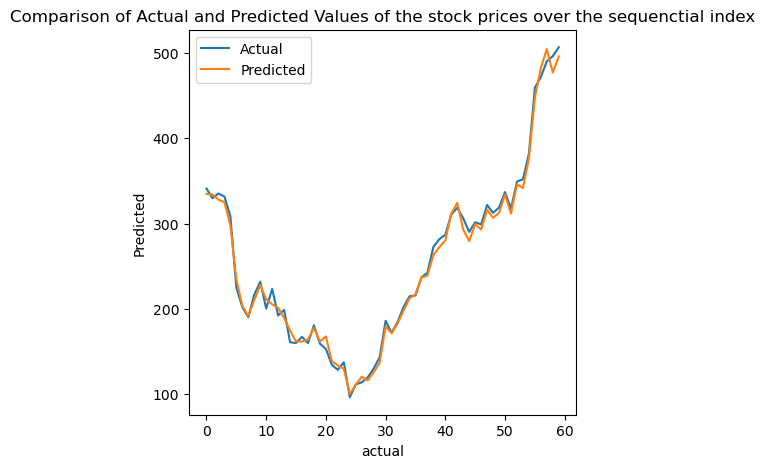

In [43]:
# Plotting the actual vs predicted values
plt.figure(figsize=(5, 5))  
plt.plot(comparison['actual'], label='Actual')
plt.plot(comparison['predicted'], label='Predicted')

plt.title('Comparison of Actual and Predicted Values of the stock prices over the sequenctial index')
plt.xlabel('actual')
plt.ylabel('Predicted')
plt.legend()

plt.show()

Plotting the actual and predicted values values of the stock price over the sequences of the crunches we have provided and we can see that almost the predicted and the actual are in close proximity.

Lets use the 9 day data and predict the 10th day by using the LSTM RNN model that is trained.


#### Predicting the 10th day closing price of Meta

In [44]:
model.predict(prior_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


array([[491.94434]], dtype=float32)

We are slicing the predicted value from the numpy array where we can see it as 491.94

In [45]:
tomorrows_sp = model.predict(prior_days)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [46]:
print(f"Tomorrow's Stock price of META is {tomorrows_sp:.2f} .")

Tomorrow's Stock price of META is 491.94 .


### Gated Recurrent Unit - GRU 

The Gated Recurring unit which is called as the GRU is a simplified version of the LSTM where gru will capture and learn from the long range of the dependencies, in gru the memory cell and the hidden state in the LSTM. The GRU trains and computes faster than the lstm and convergence will be faster.

In [71]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

Here we do have 32 units in the input layer which is the first layer and there is a hidden layer and we can see that the return sequences are set to true which means the full sequence of the outputs for each input sequence and teh actibvation function is set to relu and the input shape has been set to 9 as the sequence of the data is 9 days and the number of features that needs to be considered at every step.The output layer has only one neuron as this is a regressor probelm and the activation function will be none

The Mean Squared error is the loss function as this is a regressor problem and the optimizer is set to RMSprop where the learning rate for the each parameter is adjusted individually based on the gradients earlier behaviours. which is done by magnitude of the recent gradients and we are fitting the trained data to the model along with the train target which is the 10th day closing price and the epoch has been set on the start to 100. 

In [72]:
model.compile(loss="mse", optimizer='RMSprop')


history = model.fit(train_x, train_target, epochs=epoch_num)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 27239.0430
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14659.7988 
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1576.1636
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 60.6239
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 26.3143
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 36.8670
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 32.8994
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 53.2421
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 51.1910
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 57.5626
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 56.4365
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 52.8119
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 62.5342
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 53.0902
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 50.6167
Epoch 16/

In [73]:
model.summary()
#Predict:
y_pred = model.predict(test_x)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ (None, 9, 32)               │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,460 (76.02 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,731 (38.02 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step


Lets flatten the data as this is in three dimensional shape into one dimension to look at the plot of stock price that is actual and predicted and Here we can see the total paramters that are trainable as 9729 and the optimizer parameters are 9731


In [50]:
comparison = pd.DataFrame()
comparison['actual'] = test_target.flatten()  
comparison['predicted'] = y_pred.flatten()

Calculating the mean squared error between the actual value and the predicted

In [51]:
mse = mean_squared_error(comparison['actual'], comparison['predicted'])**0.5
print(f"Root  Mean Squared Error: {mse}")

Root  Mean Squared Error: 12.014394367545018


The Root Mean Squared error is 12.01

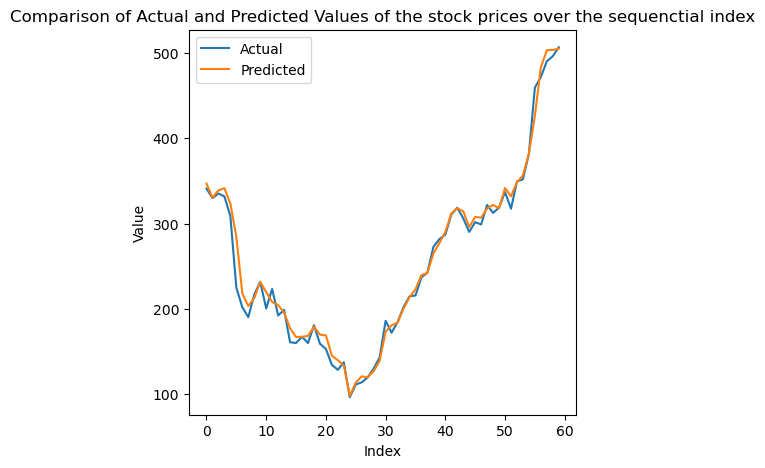

In [52]:
# Plotting the actual vs predicted values
plt.figure(figsize=(5, 5))  
plt.plot(comparison['actual'], label='Actual')
plt.plot(comparison['predicted'], label='Predicted')

plt.title('Comparison of Actual and Predicted Values of the stock prices over the sequenctial index')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.show()

Plotting the actual and predicted values values of the stock price over the sequences of the crunches we have provided and we can see that almost the predicted and the actual are in close proximity.


Lets use the 9 day data and predict the 10th day by using the RNN model that is trained.

#### Predicting the 10th day closing price of Meta

In [53]:
model.predict(prior_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[514.85614]], dtype=float32)

We are slicing the predicted value from the numpy array where we can see it as 514.86

In [54]:
tomorrows_sp = model.predict(prior_days)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [55]:
print(f"Tomorrow's Stock price of META is {tomorrows_sp:.2f} .")

Tomorrow's Stock price of META is 514.86 .


### CONV1D

The Conv1D which is one dimensional convolutional neural network, the convolution works on the one dimensional input which is not the case in the convolutional two dimensioanl convolutional network, the kernels in the conv1d recognizes the patterns in the time series, we have considered the 3 as shape of the filter which slides over the data and that computes the dot product and the stride is set to 1 as the filter which is kenrel move one slide and the padding is set to valid which means that the padding is not performed to the input sequence and the output layer has one neuron as this is a regressor problem and the return sequence has been set to true which means the sequence of the output has been fed as input in the layers.

In [74]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid", input_shape=[9, 1]),
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=True),
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

The Mean Squared error is the loss function as this is a regressor problem and the optimizer is set to ADAM and we are fitting the trained data to the model along with the train target which is the 10th day closing price and the epoch has been set on the start to 100. 

In [75]:
model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=epoch_num)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 26020.6582
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16497.1367 
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5500.0005 
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 760.5649
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 232.6145 
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 329.3219 
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 71.9277 
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 65.8629  
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 57.5455 
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.6193 
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.3920 
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.0267 
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 36.8225 
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.2306 
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.

Lets Predict the model perfomance on the test data which we have considered as the 10th day

In [76]:

#Predict:
y_pred = model.predict(test_x)
model.summary()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 7, 20)               │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_9 (SimpleRNN)             │ (None, 7, 32)               │           1,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_10 (SimpleRNN)            │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,669 (45.59 KB)

 Trainable params: 3,889 (15.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,780 (30.39 KB)

Lets flatten the data as this is in three dimensional shape into one dimension to look at the plot of stock price that is actual and predicted  and Here we can see the total paramters that are trainable as 3889 and the optimizer parameters are 7780

In [59]:
comparison = pd.DataFrame()
comparison['actual'] = test_target.flatten()  
comparison['predicted'] = y_pred.flatten()

Calculating the mean squared error between the actual value and the predicted

In [60]:
Rmse = mean_squared_error(comparison['actual'], comparison['predicted'])**0.5
print(f"Root Mean Squared Error: {mse}")

Root Mean Squared Error: 12.014394367545018


The Root Mean Squared error is 12.01

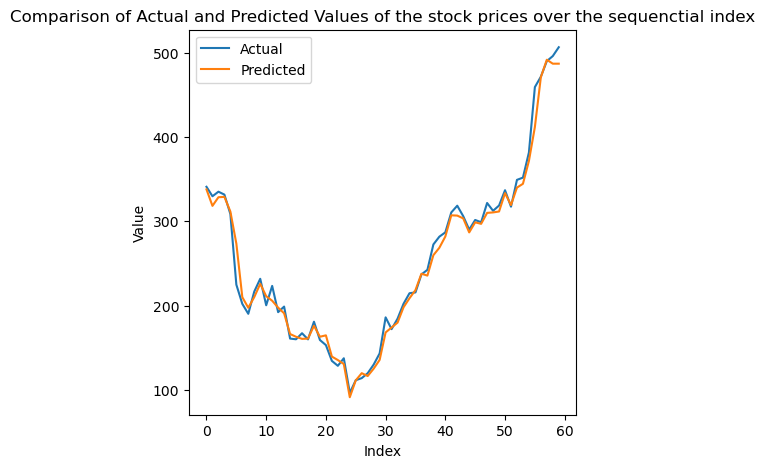

In [61]:
# Plotting the actual vs predicted values
plt.figure(figsize=(5, 5))  
plt.plot(comparison['actual'], label='Actual')
plt.plot(comparison['predicted'], label='Predicted')

plt.title('Comparison of Actual and Predicted Values of the stock prices over the sequenctial index')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.show()

Plotting the actual and predicted values values of the stock price over the sequences of the crunches we have provided and we can see that almost the predicted and the actual are in close proximity.


Lets use the 9 day data and predict the 10th day by using the RNN model that is trained.


#### Predicting the 10th day closing price of Meta

In [62]:
model.predict(prior_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


array([[496.50253]], dtype=float32)

In [63]:
tomorrows_sp = model.predict(prior_days)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


We are slicing the predicted value from the numpy array where we can see it as 508.88

In [64]:
print(f"Tomorrow's Stock price of Meta is {tomorrows_sp:.2f} .")

Tomorrow's Stock price of Meta is 496.50 .


### Summary

Here i have Considered a stock data from the yahoo finance of the Meta platforms, data from 2012 till 2024 present month  which have data of opening price, closing price and the high, low price.Stored the data into a data frame and then dropped the columns that are not required for the analysis. Considered only the closing price as that needs to be trained by the models as we are dealing with sequentual data. Considered a sequence length of 10 as we are trying to split the data into sequence crunches of 10 as we are trying to predict the 10th day Splitted the data based on it and then by using the chronological split, splitted the data into 80 % of the data into the train set and the test set as 20 which will be used for testing the model.

Then the data has been  splitted sets are then reshaped into three dimensional arrays as the recurring neural networks require that shape as input and then the models of Recurring neural network and the Long short term memory and the gated recurrent unit, convolutional 1D models has been designed and they are are compiled by different activation function in the layers where as we are trying to predict the price of the stock this will be a regressor problem hence the output layer will have the activation function as none for all the models and the Mean squared error hass been calulated for the models which measures the average squared difference between the predicted value and the actual value. Then by considering the last 9 days data then i have considered only the closing price of the last 9 days and by usning the trained model predicted the 10th day closing price of Meta Platforms as follows:


The Recurrent Neural Network
- The Root Mean Squared error is 11.47
- Closing Stock Price is 504.92 

The Long Short-Term Memory
- The Root Mean Squared error is 7.80
- Closing Stock Price is 491.94

The Gated Recurrent Unit 
- The Root  Mean Squared error is 12.01
- Closing Stock Price is 514.86

The conv1d 
- The Root Mean Squared error is 12.01
-  Closing Stock Price is 496.50

By looking at the Root mean squared error, the Gated Recurrent and the conv1d has the highest root mean squared error which provides the measure of the average magnitude of the errors in the same unit as target variable, the lowest rmse value is for the model of Long short term memory which has the lower value as 7.80 which suggest that the stock price predicted is in close with the actual value.Out of all the models even the stock price is higher for the Gated Recurrent unit model the Long short term memory has the lowest RMSE hence it is the best model that predicted the closing stock price of meta as 514.86